# Fast Neural Style Transfer

In [1]:
# https://github.com/ceshine/fast-neural-style

In [2]:
import time 

import matplotlib.pyplot as plt
import numpy as np
import torch
# For getting VGG model
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
# Image transformation pipeline
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from torch.autograd import Variable
from PIL import Image, ImageFile
from tqdm import tqdm_notebook

from fast_neural_style.transformer_net import TransformerNet
from fast_neural_style.utils import (
    gram_matrix, recover_image, tensor_normalizer
)
from fast_neural_style.loss_network import LossNetwork

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
SEED = 1081
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    kwargs = {'num_workers': 4, 'pin_memory': True}
else:
    kwargs = {}

In [4]:
# IMAGE_SIZE = 224
# BATCH_SIZE = 4
# DATASET = "./coco_2017" # Downloaded from http://images.cocodataset.org/zips/val2017.zip
# transform = transforms.Compose([
#     transforms.Resize(IMAGE_SIZE), 
#     transforms.CenterCrop(IMAGE_SIZE),
#     transforms.ToTensor(), tensor_normalizer()])
# # http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder
# train_dataset = datasets.ImageFolder(DATASET, transform)
# # http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    loss_network = LossNetwork()
    loss_network.to(device)
loss_network.eval()

LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [6]:
# STYLE_IMAGE = "./style_images/mosaic.jpg"
# # STYLE_IMAGE = "./style_images/candy.jpg"
# style_img = Image.open(STYLE_IMAGE).convert('RGB')
# with torch.no_grad():
#     style_img_tensor = transforms.Compose([
#         # transforms.Resize(IMAGE_SIZE* 2),
#         transforms.ToTensor(),
#         tensor_normalizer()]
#     )(style_img).unsqueeze(0)
#     # assert np.sum(style_img - recover_image(style_img_tensor.numpy())[0].astype(np.uint8)) < 3 * style_img_tensor.size()[2] * style_img_tensor.size()[3]
#     style_img_tensor = style_img_tensor.to(device)

In [7]:
# plt.imshow(recover_image(style_img_tensor.cpu().numpy())[0])

Precalculate gram matrices of the style image:

In [8]:
# # http://pytorch.org/docs/master/notes/autograd.html#volatile
# with torch.no_grad():
#     style_loss_features = loss_network(style_img_tensor)
#     gram_style = [gram_matrix(y) for y in style_loss_features]

In [9]:
# for i in range(len(style_loss_features)):
#     tmp = style_loss_features[i].cpu().numpy()
#     print(i, np.mean(tmp), np.std(tmp))

## Train the Transformer / Image Generator
Utility function to save debug images during training:

In [10]:
# def save_debug_image(tensor_orig, tensor_transformed, tensor_with_noise, filename):
#     assert tensor_orig.size() == tensor_transformed.size()
#     result = Image.fromarray(recover_image(tensor_transformed.cpu().numpy())[0])
#     noise = Image.fromarray(recover_image(tensor_with_noise.cpu().numpy())[0])
#     orig = Image.fromarray(recover_image(tensor_orig.cpu().numpy())[0])
#     new_im = Image.new('RGB', (result.size[0] * 3 + 10, result.size[1]))
#     new_im.paste(orig, (0,0))
#     new_im.paste(result, (result.size[0] + 5,0))
#     new_im.paste(noise, (result.size[0] * 2 + 10,0))
#     new_im.save(filename)

In [11]:
transformer = TransformerNet()
mse_loss = torch.nn.MSELoss()
# l1_loss = torch.nn.L1Loss()
transformer.to(device)

TransformerNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (res1): ResidualBlock(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (in1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (

In [12]:
# torch.set_default_tensor_type('torch.FloatTensor')
   
# def train(steps, base_steps=0):
#     transformer.train()
#     count = 0
#     agg_content_loss = 0.
#     agg_style_loss = 0.
#     agg_reg_loss = 0.   
#     agg_stable_loss = 0.
#     while True:
#         for x, _ in train_loader:
#             count += 1
#             optimizer.zero_grad()
#             x = x.to(device)             
#             y = transformer(x)            
#             with torch.no_grad():                      
#                 mask = torch.bernoulli(torch.ones_like(
#                     x, device=device, dtype=torch.float
#                 ) * NOISE_P)
#                 noise = torch.normal(
#                     torch.zeros_like(x), 
#                     torch.ones_like(
#                         x, device=device, dtype=torch.float
#                     ) * NOISE_STD
#                 ).clamp(-1, 1)
#                 # print((noise * mask).sum())
#             y_noise = transformer(x + noise * mask)
                        
#             with torch.no_grad():
#                 xc = x.detach()
#                 features_xc = loss_network(xc)
            
#             features_y = loss_network(y)
            
#             with torch.no_grad():
#                 f_xc_c = features_xc[2].detach()

#             content_loss = CONTENT_WEIGHT * mse_loss(features_y[2], f_xc_c)

#             reg_loss = REGULARIZATION * (
#                 torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
#                 torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

#             style_loss = 0.
#             for l, weight in enumerate(STYLE_WEIGHTS):
#                 gram_s = gram_style[l]
#                 gram_y = gram_matrix(features_y[l])
#                 style_loss += float(weight) * mse_loss(gram_y, gram_s.expand_as(gram_y))
                
#             stability_loss = NOISE_WEIGHT * mse_loss(y_noise.view(-1), y.view(-1).detach())

#             total_loss = content_loss + style_loss + reg_loss + stability_loss
#             total_loss.backward()
#             optimizer.step()

#             agg_content_loss += content_loss
#             agg_style_loss += style_loss
#             agg_reg_loss += reg_loss
#             agg_stable_loss += stability_loss

#             if count % LOG_INTERVAL == 0:
#                 mesg = "{} [{}/{}] content: {:.2f}  style: {:.2f}  reg: {:.2f} stable: {:.2f} total: {:.6f}".format(
#                             time.ctime(), count, steps,
#                             agg_content_loss / LOG_INTERVAL,
#                             agg_style_loss / LOG_INTERVAL,
#                             agg_reg_loss / LOG_INTERVAL,
#                             agg_stable_loss / LOG_INTERVAL,
#                             (agg_content_loss + agg_style_loss + 
#                              agg_reg_loss + agg_stable_loss) / LOG_INTERVAL
#                         )
#                 print(mesg)
#                 agg_content_loss = 0.
#                 agg_style_loss = 0.
#                 agg_reg_loss = 0.
#                 agg_stable_loss = 0.
#                 transformer.eval()
#                 y = transformer(x)
#                 save_debug_image(x, y.detach(), y_noise.detach(), "./debug/{}.png".format(base_steps + count))
#                 transformer.train()
                
#             if count >= steps:
#                 return

In [13]:
# CONTENT_WEIGHT = 1
# STYLE_WEIGHTS = np.array([1e-1, 1, 1e1, 5, 1e1]) * 5e3
# REGULARIZATION = 1e-6
# NOISE_P = 0.2
# NOISE_STD = 0.35
# NOISE_WEIGHT = 10 * 2
# LOG_INTERVAL = 50

# LR = 1e-3
# optimizer = Adam(transformer.parameters(), LR)

In [14]:
# train(200, 0)

In [15]:
# save_model_path = "./models/mosaic_style__200_iter__vgg19_weights.pth"
# torch.save(transformer.state_dict(), save_model_path)

In [16]:
# import glob
# fnames = glob.glob(DATASET + r"/*/*")
# len(fnames)

In [17]:
# transformer = TheModelClass(*args, **kwargs)
transformer.load_state_dict(torch.load("./models/coq_au_vin_style__200_iter__vgg19_weights.pth")) # https://pytorch.org/tutorials/beginner/saving_loading_models.html

<All keys matched successfully>

In [18]:
transformer = transformer.eval()

torch.Size([1, 3, 512, 768])


C:\Users\datta\AppData\Local\Continuum\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # This is added back by InteractiveShellApp.init_path()


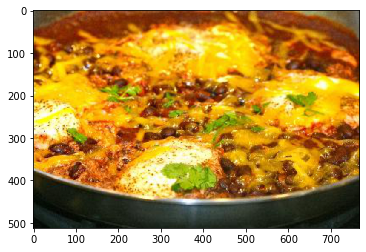

In [19]:
img = Image.open("./content_images/test_000000.jpg").convert('RGB')
transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    tensor_normalizer()])
img_tensor = transform(img).unsqueeze(0)
print(img_tensor.size())
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(Variable(img_tensor, volatile=True))
plt.imshow(recover_image(img_tensor.cpu().numpy())[0])

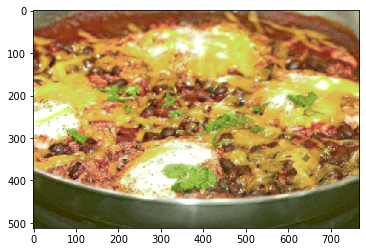

In [20]:
plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

In [21]:
# img = Image.open("./content_images/amber.jpg").convert('RGB')
# transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.ToTensor(),
#     tensor_normalizer()])
# img_tensor = transform(img).unsqueeze(0)
# print(img_tensor.size())
# if torch.cuda.is_available():
#     img_tensor = img_tensor.cuda()

# img_output = transformer(Variable(img_tensor, volatile=True))
# plt.imshow(recover_image(img_output.data.cpu().numpy())[0])

In [22]:
# output_img = Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])
# output_img.save("amber.png")